# **Training Deep Neural Networks**

In [ ]:
import tensorflow as tf
from tensorflow import keras

## The Vanishing/Exploding Gradients Problems

Backpropagation works by going from the output layer to the input layer, propagating the error gradient along the way. After computing the gradient of the cost function with regard to each parameter in the network, it uses the gradients to update each parameter with a Gradient Descent step.

Gradients often get smaller as the algorithm progresses down to lower layers. As a result, the Gradient Descent update leabes the lower layers' connection weights virtually unchanged, and training never converges to a good solution. This is the *vanishing gradients* problem. 

In some cases, the opposite can happen: the gradients can grow bigger until layers get insanely large weight updates and the algorithm diverges. This is the *exploding gradients* problem (recurrent neural networks).

Looking at logistic activation function, when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is nothing left for the lower layers.

### Glorot and He Initialization

Glorot and Bengio proposed that the signal needs to flow properly in both directions: in the foward direction when making predictions, and the reverse direction when backpropagating gradients. For the signal to flow properly, they argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing througha layer in the reverse direction. It's not possible to gurantee both, so they proposed a compromise. Connection weights of each layer must be initialized randomly using:

$fan_{avg} = (fan_{in} + fan_{out}) / 2$

|Initialization|Activation Functions|$\sigma^{2}$ (Normal)|
|--------------|:-------------------|:-------------------|
|Glorot |None, tanh, logistic, softmax| $1/fan_{avg}$|
|He|ReLU and variants| $2/fan_{in}$|
|LeCunn|SELU|$1/fan_{in}$|




Replacing $fan_{avg}$ with $fan_{in}$ yields LeCunn initialization. LeCunn and Glorot initialization are equivalent when $fan_{in}$ = $fan_{out}$

By default, Keras uses Glorot with a uniform distribution. Can be changed to He initialization:

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

For He initialization with uniform dist but based on $fan_{avg}$ rather than $fan_{in}$, use `VarianceScaling`:

In [ ]:
he_avg_init = keras.initializer.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

### Nonsaturating Activation Functions

Other activation functions (besides sigmoid) work better on Deep Networks. Especially ReLU.

ReLU isn't perfect though. It suffers from *dying ReLUs*: during training, some neurons "die" meaning they stop outputting anything other than 0. A neuron dies when its weights are tweaked in a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it keeps outputting zeros, and Gradient Descent does not affect it anymore beacuse the gradient of ReLU is zero when its input is negative. 

**LeakyReLU**

To solve this, use *Leaky ReLU*. Ensures that neurons never die. Defined as:<br>
$LeakyReLU_{\alpha}(z) = max(\alpha z, z)$

$\alpha$ defines how much the function "leaks": it's the slope of the function for z<0 and is typically set to 0.01. 

PReLU also outperforms ReLU in many cases. $\alpha$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter)

**ELU**

Outperforms all ReLU variants

![elu_formula](elu_form.png)

![elu](ELU.png)

Main drawback is that it is slower to compute than ReLU (due to the use of exponential function)

**SELU**

scaled variant of ELU. Authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, it outperforms other activations. However, some conditions must be met for self-normalization to happen:
- Input features must be standardized ($\mu$=0, $\sigma$=1)
- Every hidden layer's weights must be initialized with LeCunn normal initialization. In Keras, `kernel_initializer="lecun_normal"`
- Network architecture must be sequential
- All layers are dense

To use leaky ReLU activation function:

In [ ]:
model = keras.models.Sequential([
    [...]
    keras.layer.Dense(10, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    [...]
])

For PReLU, replace `LeakyReLU(alpha=0.2)` with `PReLU()`

For SELU:

In [ ]:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

### Batch Normalization

Significantly reduces possibility of vanishing/exploding gradients. Consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. I.e., the operation lets the model learn the optimal scale and mean of each of the layer's inputs. 

Led to huge improvement in the ImageNet classification task (large database of images classified into many classes, commonly used to evaluate computer vision systems). Vanishing gradients problem was strongly reduced, to the point they could use saturating activation functions such as tanh and logistic activation function. Networks were also much less sensitive to weight initialization. They were able to use larger learning rates, significantly speeding up the learning process. It also acts like a regularizer.

**Implementing Batch Normalization with Keras**

Add `BatchNormalization` layer before or after each hidden layer's activation function; optionally add BN layer as the first layer in model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
>>> model.summary()

In [ ]:
>>> [(var.name, var.trainable) for var in model.layers[1].variables]

To add BN layers before the activation functions, remove activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since BN layers include one offset parameter per input, you can remove the bias term from previous layer:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, 'softmax')
])

Update `momentum` hyperparameter for BN. It is used by BN when it updates the exponential moving average. Good values are close to 1; e.g, 0.9, 0.99, 0.999 (you want more 9s for larger datasets and smaller mini-batches).

`axis` hyperparameter determines which axis should be normalized. Defaults to -1, meaning that it will normalize the last axis (using the means and std computed across the *other* axes). When inpt batch is 2D ([*batch size, features*]), each input feature will be normalized based on the mean and std computed across all the instances in the batch. E.g., first BN layer in the previous code example will independetly normalize (and rescale and shift) 784 input features. If we move the first BN layer before the `Flatten` layer, the input batches will be 3D ([*batch size, height, width*]); therefore, the BN layer will compute 28 means and 28 std (1 per column of pixels, compputed across all instances in the batch and across all rows in the column). If you want to treat each of the 784 pixes independently, set `axis=[1, 2]`

### Gradient Clipping

Clip gradients during backpropagation so they never exceed some threshold; another technique to mitigate the exploding gradients. Often used in RNN, since BN is tricky to use in RNNs.

Keras implementation:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

Optimizer will clip every component of the gradient vector to a value between -1.0 and 1.0. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its $l_{2}$ norm is greater than the threshold you picked. If gradients explode during training, try both clipping by value and nrom, with different thresholds, see which option performs best on validation

## Reusing Pretrained Layers

*Transfer Learning*: resuing lower layers of a prexisting (similar) network to accomplish a task

The more similar the tasks are the more layers you want to reuse. 

### Transfer Learning with Keras

Suppose the Fashion MNIST dataset contained only 8 classes (all the classes except shirt and sandal). Someone built and trained a Keras model on that set and got good performance (>90% accuracy). Call this model A. You want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (0=shirt, 1=sandal). Your dataset is quite small (200 labeled images). When you train a new model for this task (model B) with the same architecture as model A, it performs well (97% accuracy). Since it's a similar task to model A, transfer learning might help.

In [ ]:
model_A = keras.models.load_model('my_model_A.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) # reuse all the layers except output layer
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

Note new model shares layers with model A, so training will affect the layers in model A as well. You must clone model A to use its layers. Clone model A's architecture with `clone_model()` then copy its weights (`clone_model()` does not clone weights).

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now you can train `model_B_on_A` for task B. But output layer was initialized randomly, it will make large errors, so there will be large error gradients that may wreck the reused weights. To avoid, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. Set every layer's `trainable` attribute to `False` and compile the model:

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

Now you can train the model for the first few epochs, then unfreeze the reused layers (requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing layers, reduce the learning rate, once again to avoid damaging the reused weights:

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=[X_valid_B, y_valid_B])

for layer in model_B_on_A[:-1]:
    layer.trainable = True

optimzer = keras.optimizers.SGD(lr=1e-4) # default lr is 1e-2
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Transfer learning works best with deep CNN, whcih tend to learn feature detectors that are much more general

### Unsupervised Pretraining

If you can gather unlabeled training data, you can use it to train an unsupervised model, such as an autoencoder or generative adversarial network. Useful when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

### Pretraining on an Auxiliary Task

If you do not have much labeled training data, one option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for you actual task. The first neural network's lower layers will learn feature detectors that will likely be reusable by the second neural network.

## Faster Optimizers

- Momentum optimization
- Nesterov Accelerated Gradient
- AdaGrad
- RMSProp
- Adam and Nadam optimization

### Momentum Optimization

Where Gradient Descent is like taking small steps to find out which direction to go toward, momentum optimization is like rolling a bowling ball down a gentle slope. It'll pick up momentum until it finds a terminal velocity (if there is some friction).

Cares about what the previous gradients were: at each iteration it subtracts the local gradient from the *momentum vector* **m** and it updates the weights by adding this momentum vector. Gradient is used for acceleration not speed. Algorithm introduces hyperparameter $\beta$ for friction set between 0 (high friction) and 1 (no friction). Typical value is 0.9.

In [ ]:
optimizer = keras.optimizer.SGD(lr=0.001, momentum=0.9)

Drawback is that it adds another hyperparameter to tune. But 0.9 is usually fine.

### Nesterov Accelerated Gradient

Variant of momentum optimization. Measures a gradient of the cost function not at the local position, but slightly ahead in the direction of the momentum. Generally faster than momentum optimization.

In [ ]:
optimizer = keras.optimizer.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

Scales down the gradient vector along the steepest dimensions

The algorithm decays the learning rate, but does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps the resulting updates more directly toward the global optimum.

Performs well for simple quadratic problems, but often stops too early when training neural networks. 

### RMSProp

Fixes AdaGrad from stopping early by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). Decay rate $\beta$ is usually 0.9. Again, another hyperparameter to tune but the default value usually works well.

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

Note `rho` corresponds to $\beta$. Except on very simple problems, almost always works better than AdaGrad.

### Adam and Nadam Optimization

*Adaptive moment estimation* combines momentum optimization and RMSProp: like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

*AdaMax*: Adam scales down the parameter updates by the $l_{2}$ norm of the time-decayed gradients (recall that the $l_{2}$ norm is the square root of the sum of squares). AdaMax replaces the $l_{2}$ norm with the  $l_{∞}$ norm (fancy way of saying the max).

*Nadam*: Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

## Learning Rate Scheduling

- Power scheduling
- Exponential scheduling
- Piecewise constant scheduling
- Performance scheduling
- 1cycle scheduling

Power scheduling. `decay` is inverse of *s* (number of steps it takes to divide the learning rate by one more unit), Keras assumes *c* is equal to 1:

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

Exponential and piecewise constant scheduling require defining a function that takes the current epoch and returns the learning rate.

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

to avoid hardcoding $\eta_{0}$ and *s*, create a function that returns a configured function

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Create a `LearningRateScheduler` callback

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler])

Schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function multiplies the previous learning rate by $0.1^{1/20}$ which results in the same exponential decay (except the decay now starts at the beginning of the epoch 0 instead of 1):

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1/20)

Relies on the optimizer's initial learning rate. Make sure to set it appropriately

Optimizer and learning rate get saved when saving a model. `epoch` argument of schedule function does not. It gets reset to 0 every time you call `fit()`. Manually set the `fit()` method's `initial_epoch` argument so the `epoch` starts at the right value.

For piecewise constant scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

For performance scheduling, use `ReduceLROnPlateau` callback. E.g., if you pass the following callback to the `fit()` method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs:

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

tf.keras offers an alternative to implement learning rate scheduling: define the learning rate using one of the schedules available in `keras.optimizers.schedules`, then pass this learning rate to any optimizer

In [ ]:
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

Summary: exponential decay, peformance, and 1cycle schedling can considerably speed up convergence

## Avoid Overfitting Through Regularization

Already looked at Early Stopping and Batch Normalization (designed to solve unstable gradients problems but also acts like a pretty good regularizer). Let's look at more:

### $ℓ_{1}$ and $ℓ_{2}$ Regularization

You can use $ℓ_{2}$ regularization to constrain a neural network's connection weights, and/or $ℓ_{1}$ regularization if you want a sparse model (with many weights equal to 0)

In [ ]:
layer = keras.layers.Dense(100, activation='elu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(0.01))

`l2()` returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. Use `keras.regularizers.l1()` if you want $ℓ_{1}$ regularization; for both use `keras.regularizers.l1_l2()`

To avoid repeating the same initialization strategy in all hidden layer, use loops or Python's `functools.partial()`

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                            activation='elu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax',
                        kernel_initializer='glorot_uniform')
])

### Dropout

*Dropout* is one of the most popular regularization techniques for deep neural networks

At every training setp, every neuron (including the input neurons, but always excluding the output neurons) has a probability *p* of being temporarily "dropped out", meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter *p* is called the *dropout rate*, and is typically set between 10% and 50%: closer to 20-30% in RNNs, and closer to 40-50% in CNNs. After training, neurons don't get dropped anymore. 

Dropout essentially creates a new, smaller neural network at each training step. The resulting neural network can be seen as an averaging ensemble of all these smaller networks. 

One caveat, we must multiply each input connection weight by the *keep probability* (1-*p*) after training. Alternatively, we can divide each neuron's output by the keep probability during training.  

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])

If the model is overfitting, you can increase the dropout rate. Conversely, you should decrease it if the model underfits the training set. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.

### Monte Carlo (MC) Dropout

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)

`model(X)` is similar to `model.predict(X)` except it returns a tensor rather than a NumPy array, and it supports the `training` argument

We make 100 predictions over the test set, and we stack them. Each call to the model returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so `y_probas` is an array of [100, 10000, 10]. Once we average over the first dimension (axis=0) we get `y_proba`, an array of shape [10000, 10], like we would get with a single prediction

Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off. 

If your model contains other layers that behave in a special way during training (such as `BatchNormalization`), then you should not force training mode like we just did. Instead, replace the `Dropout` layers with the following `MCDropout` class:

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### Max-Norm Regluarization

For each neuron, it constrains the weights **w** of the incoming connections such that ||**w**||$_{2}$ ≤ *r*, where *r* is the max-norm hyperparameter and ||.||$_{2}$ is the $ℓ_{2}$ norm

Does not add a regularization loss term to the overall loss function. Instead, it computes ||**w**||$_{2}$ after each training step and rescaling **w** if needed <br> 
(**w** <- **w** *r*/||**w**||$_{2}$)

Reducing *r* increases the amount of regularization and helps reduce overfitting. Can also help alleviate unstable gradients problem (if you are not already using Batch Normalization)

In [ ]:
keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal', 
                    kernel_constraint=keras.constraints.max_norm(1.))

## Summary and Practical Guidelines

Default DNN configuration

|Hyperparameter        |Default value                              |
|:---------------------|:------------------------------------------|
|Kernel initializer    |He initialization                          |
|Activation function   |ELU                                        |
|Normalization         |None if shallow; Batch norm if deep        |
|Regularization        |Early stopping (+$ℓ_{2}$ reg if needed)    |
|Optimizer             |Momentum optimization (or RMSProp or Nadam)|
|learning rate schedule|1cycle                                     |

If network is simple stack of dense layers, use the following:

DNN configuration for self-normalizing net

|Hyperparameter        |Default value                              |
|:---------------------|:------------------------------------------|
|Kernel initializer    |LeCun initialization                       |
|Activation function   |SELU                                       |
|Normalization         |None (self-normalization)                  |
|Regularization        |Alpha dropout if needed                    |
|Optimizer             |Momentum optimization (or RMSProp or Nadam)|
|learning rate schedule|1cycle                                     |

Don't forget to normalize input features

Try to reuse parts of a pertrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of ulabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task

Some exceptions:
- If you need a sparse model, you can use $ℓ_{1}$ regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can use the Tensorflow Model Optimization Toolkit. This will break self-normalization, so you should use the default configuration in this case
- If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU. Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits (see "Deploying a Model to a Mobile or Embedded Device" on page 685). Again, check out TF-MOT. 
- If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates. 

# Exercises

1. **Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?**
<br>
No, all the values should be sampled independently.

2. **Is it OK to initialize the bias terms to 0?**<br>
It doesn't make a difference

3. **Name three advantages of the SELU activation function over ReLU.**<br>
    1. self-normalize (if conditions are right)
    2. it can take on negative values (helps solve vanishing/exploding gradients problem)
    3. always has a nonzero derivative (avoids dying ReLUs)

4. **In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?**<br>
- SELU: good default
- leaky ReLU: faster training
- ReLU: simplicity makes it a good alternative default despite it being outperformed by SELU and leaky ReLU
- tanh: if you need to output a number between -1 and 1
- logistic: if you need to estimate a probability
- softmax: in the output layer to output probabilities for mutually exclusive classes

5. **What may happen if you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer?**<br>
Too little friction causes the algorithm to overshoot the global optimum, which will make it oscillate many times before converging

6. **Name three ways you can produce a sparse model.**<br>
    1. zero out tiny weights
    2. $ℓ_{1}$ regularization
    3. TensorFlow Model Optimization Toolkit

7. **Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?**<br>
Dropout slows down training (roughly by a factor of 2) but not inference (since it is only active during training). MC dropout slows down training and inference (slightly). You also want to run inference 10 times or more to get better predictions (slowing down inference by a factor of 10).

8. **Practice training a deep neural network on the CIFAR10 image dataset:**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

- **Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.**

In [2]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [3]:
def build_cifar(n_hidden=20, n_neurons=100, learning_rate=1e-3, input_shape=[32,32,3], 
                activation='elu', kernel_initializer='he_normal', 
                batch_normalization=False, dropout=False):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for _ in range(n_hidden):
        if batch_normalization:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.AlphaDropout(rate=0.2))
        model.add(keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [4]:
import matplotlib.pyplot as plt
from keras import backend as K
import math

class LRFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9
    
    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return
        
        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)
    
    def find(self, X_train, y_train, start_lr, end_lr, batch_size=32, epochs=2):
        num_batches = epochs * X_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = keras.callbacks.LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback])
        
        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, xlim=(1e-9,1), ylim=(0,10)):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """

        plt.ylabel('loss')
        plt.xlabel('learning rate (log scale)')
        plt.plot(self.lrs, self.losses)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xscale('log')

- **Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with the `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32x32-pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.**

In [5]:
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [39]:
X_train.shape, X_valid.shape, X_test.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

In [40]:
y_train.shape, y_valid.shape, y_test.shape

((45000,), (5000,), (10000,))

Find optimal learning rate

In [79]:
base_cifar = build_cifar()
lr_finder = LRFinder(base_cifar)
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=100, batch_size=512, epochs=5)

Epoch 1/5
88/88 [==============================] - 4s 26ms/step - loss: 3.5401 - accuracy: 0.1151
Epoch 2/5
88/88 [==============================] - 2s 24ms/step - loss: 2.9488 - accuracy: 0.1581
Epoch 3/5
88/88 [==============================] - 2s 26ms/step - loss: 704167680.0000 - accuracy: 0.1010
Epoch 4/5
88/88 [==============================] - 2s 24ms/step - loss: 3.3170 - accuracy: 0.1002
Epoch 5/5
88/88 [==============================] - 2s 22ms/step - loss: 104.0750 - accuracy: 0.1026


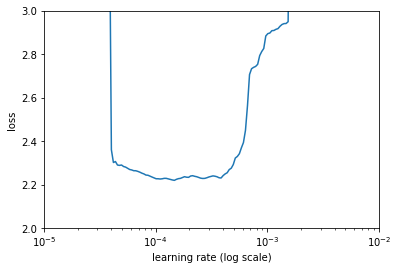

In [80]:
lr_finder.plot_loss(xlim=(1e-5, 1e-2), ylim=(2, 3))
plt.show()

In [81]:
K.set_value(base_cifar.optimizer.learning_rate, 1e-4)
base_cifar.fit(
    X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb])

Epoch 1/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.9996 - accuracy: 0.2728 - val_loss: 1.8797 - val_accuracy: 0.3226
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.7850 - accuracy: 0.3539 - val_loss: 1.7658 - val_accuracy: 0.3530
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6964 - accuracy: 0.3918 - val_loss: 1.7924 - val_accuracy: 0.3576
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6386 - accuracy: 0.4138 - val_loss: 1.6854 - val_accuracy: 0.3888
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5942 - accuracy: 0.4288 - val_loss: 1.6369 - val_accuracy: 0.4094
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5568 - accuracy: 0.4429 - val_loss: 1.5939 - val_accuracy: 0.4240
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5246 - accuracy: 0.4530 - val_loss: 1.5934

- **Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?**

In [83]:
bn_cifar = build_cifar(batch_normalization=True)
lr_finder = LRFinder(bn_cifar)
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=100, batch_size=512, epochs=5)

Epoch 1/5
88/88 [==============================] - 9s 42ms/step - loss: 3.2480 - accuracy: 0.0952
Epoch 2/5
88/88 [==============================] - 4s 40ms/step - loss: 2.3327 - accuracy: 0.2192
Epoch 3/5
88/88 [==============================] - 4s 40ms/step - loss: 2.0069 - accuracy: 0.2995
Epoch 4/5
88/88 [==============================] - 4s 40ms/step - loss: 117.7062 - accuracy: 0.1161
Epoch 5/5
88/88 [==============================] - 4s 40ms/step - loss: 44831.0938 - accuracy: 0.0997


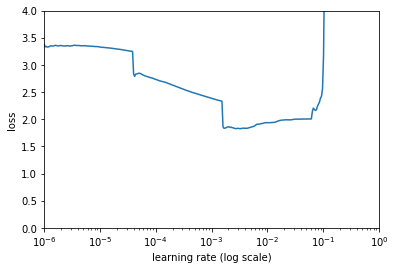

In [91]:
lr_finder.plot_loss(xlim=(1e-6, 1), ylim=(0,4))
plt.show()

In [92]:
K.set_value(bn_cifar.optimizer.learning_rate, 1e-3)
bn_cifar.fit(
    X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb])

Epoch 1/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.9971 - accuracy: 0.2861 - val_loss: 1.8837 - val_accuracy: 0.3278
Epoch 2/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.8719 - accuracy: 0.3291 - val_loss: 1.7761 - val_accuracy: 0.3558
Epoch 3/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.7855 - accuracy: 0.3598 - val_loss: 1.7333 - val_accuracy: 0.3712
Epoch 4/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.7286 - accuracy: 0.3819 - val_loss: 1.6729 - val_accuracy: 0.3914
Epoch 5/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.6874 - accuracy: 0.3987 - val_loss: 1.6277 - val_accuracy: 0.4142
Epoch 6/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.6604 - accuracy: 0.4084 - val_loss: 1.5907 - val_accuracy: 0.4332
Epoch 7/100
1407/1407 [==============================] - 22s 15ms/step - loss: 1.6319 - accuracy: 0.4197 - val_loss: 1

- **Try replacing Batch Normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).**

In [6]:
X_train_scaled = (X_train - X_train.mean()) / X_train.std()
X_valid_scaled = (X_valid - X_valid.mean()) / X_valid.std()

In [8]:
norm_cifar = build_cifar(activation='selu', kernel_initializer='lecun_normal')
lr_finder = LRFinder(norm_cifar)
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=100, batch_size=512, epochs=5)

Epoch 1/5
88/88 [==============================] - 4s 25ms/step - loss: 2.5615 - accuracy: 0.1274
Epoch 2/5
88/88 [==============================] - 2s 25ms/step - loss: 2.5247 - accuracy: 0.1758
Epoch 3/5
88/88 [==============================] - 2s 21ms/step - loss: 7295250432.0000 - accuracy: 0.0975


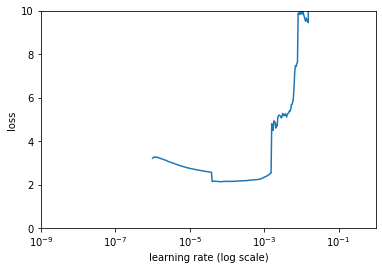

In [9]:
lr_finder.plot_loss()
plt.show()

In [10]:
K.set_value(norm_cifar.optimizer.learning_rate, 1e-3)
norm_cifar.fit(
    X_train_scaled, y_train, epochs=100,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping_cb])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.8899 - accuracy: 0.3216 - val_loss: 1.9213 - val_accuracy: 0.2854
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.7152 - accuracy: 0.3836 - val_loss: 1.7453 - val_accuracy: 0.3826
Epoch 3/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.6396 - accuracy: 0.4189 - val_loss: 1.7026 - val_accuracy: 0.3982
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.5942 - accuracy: 0.4340 - val_loss: 1.6451 - val_accuracy: 0.4204
Epoch 5/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.5572 - accuracy: 0.4479 - val_loss: 1.6641 - val_accuracy: 0.4072
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5217 - accuracy: 0.4629 - val_loss: 1.7025 - val_accuracy: 0.4028
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5019 - accuracy: 0.4706 - val_loss: 1.6140 

- **Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.**

In [31]:
drop_cifar = build_cifar(dropout=True)
lr_finder = LRFinder(drop_cifar)
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=100, batch_size=512, epochs=5)

Epoch 1/5
88/88 [==============================] - 6s 40ms/step - loss: 3.7121 - accuracy: 0.0992
Epoch 2/5
88/88 [==============================] - 3s 40ms/step - loss: 3.2130 - accuracy: 0.0986
Epoch 3/5
88/88 [==============================] - 3s 37ms/step - loss: 8829256335360.0000 - accuracy: 0.1025


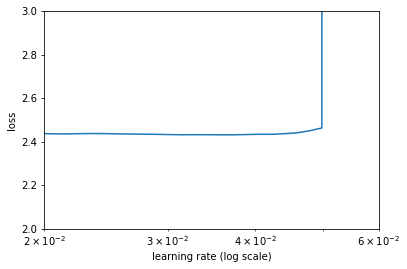

In [32]:
lr_finder.plot_loss(xlim=(2e-2,6e-2), ylim=(2,3))
plt.show()

In [33]:
K.set_value(drop_cifar.optimizer.learning_rate, 5e-2)
drop_cifar.fit(
    X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb])

Epoch 1/100
1407/1407 [==============================] - 16s 12ms/step - loss: 210198432.0000 - accuracy: 0.1002 - val_loss: 2.3095 - val_accuracy: 0.0952
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 692484.1875 - accuracy: 0.0999 - val_loss: 2.3173 - val_accuracy: 0.1018
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 77.6134 - accuracy: 0.0996 - val_loss: 2.3144 - val_accuracy: 0.0972
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 4.2360 - accuracy: 0.1023 - val_loss: 2.3131 - val_accuracy: 0.1008
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 3.6521 - accuracy: 0.1016 - val_loss: 2.3229 - val_accuracy: 0.1054
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 66.4436 - accuracy: 0.1005 - val_loss: 2.3123 - val_accuracy: 0.1018
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 6.6484 - accuracy: 0.101

In [35]:
y_probas = np.stack([drop_cifar(X_valid, training=False) for _ in range(100)])
y_proba = y_probas.mean(axis=0)

In [36]:
score = 0
for i, instance in enumerate(y_proba):
    if y_valid[i] == instance.argmax():
        score += 1
print(score / len(X_valid))

0.0952


- **Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.**

In [45]:
def one_cycle_schedule(lrmin=1e-6, lrmax=1e-2, time=20):
    def one_cycle_fn(epoch):
        climb = (lrmax-lrmin) / time
        if epoch < time:
            return lrmin + climb * epoch
        else:
            lr = lrmax - climb * (epoch-time)
            return lr if lr < lrmin else lr / 10.0
    return one_cycle_fn

one_cycle_cb = keras.callbacks.LearningRateScheduler(one_cycle_schedule(lrmin=1e-5, lrmax=1e-4, time=20))

In [46]:
oc_cifar = build_cifar()
oc_cifar.fit(
    X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb, one_cycle_cb]
)

Epoch 1/100
1407/1407 [==============================] - 14s 9ms/step - loss: 2.0905 - accuracy: 0.2488 - val_loss: 1.9122 - val_accuracy: 0.3040
Epoch 2/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.8392 - accuracy: 0.3319 - val_loss: 1.8219 - val_accuracy: 0.3378
Epoch 3/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.7467 - accuracy: 0.3684 - val_loss: 1.7547 - val_accuracy: 0.3558
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.6809 - accuracy: 0.3919 - val_loss: 1.6879 - val_accuracy: 0.3916
Epoch 5/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.6292 - accuracy: 0.4106 - val_loss: 1.6345 - val_accuracy: 0.4180
Epoch 6/100
1407/1407 [==============================] - 12s 9ms/step - loss: 1.5873 - accuracy: 0.4261 - val_loss: 1.6649 - val_accuracy: 0.4028
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.5520 - accuracy: 0.4414 - val_loss: 1.6160 -